## The CCAO Dataset

This dataset comes from the Cook County Assessor’s Office (CCAO) in Illinois, a government institution that determines property taxes across most of Chicago’s metropolitan area and its nearby suburbs. In the United States, all property owners are required to pay property taxes, which are then used to fund public services including education, road maintenance, and sanitation. These property tax assessments are based on property values estimated using statistical models that consider multiple factors, such as real estate value and construction cost.

This system, however, is not without flaws. In late 2017, a lawsuit was filed against the office of Cook County Assessor Joseph Berrios for producing “[racially discriminatory assessments and taxes](https://www.chicagotribune.com/politics/ct-cook-county-board-assessor-berrios-met-20170718-story.html)." The lawsuit included claims that the assessor’s office undervalued high-priced homes and overvalued low-priced homes, creating a visible divide along racial lines: Wealthy homeowners, who were typically white, [paid less in property taxes](https://www.clccrul.org/bpnc-v-berrios-facts?rq=berrios), whereas [working-class, non-white homeowners paid more](https://www.chicagotribune.com/news/breaking/ct-cook-county-assessor-berrios-sued-met-20171214-story.html).

The Chicago Tribune's four-part series, "[The Tax Divide](https://www.chicagotribune.com/investigations/ct-tax-divide-investigation-20180425-storygallery.html)", delves into how this was uncovered: After "compiling and analyzing more than 100 million property tax records from the years 2003 through 2015, along with thousands of pages of documents, then vetting the findings with top experts in the field," they discovered that "residential assessments had been so far off the mark for so many years." You can read more about their investigation [here](https://apps.chicagotribune.com/news/watchdog/cook-county-property-tax-divide/assessments.html).

This presents ethical concerns about the algorithms used to predict housing prices, thus, the associated property taxes for houses in certain neighborhoods.

<!-- END QUESTION -->

<br><br>

<hr style="border: 1px solid #fdb515;" />

## Preparing Data

In [ ]:
# This makes the train-validation split in this section reproducible across different runs 
# of the notebook. You do not need this line to run train_val_split in general

np.random.seed(1337)

def train_val_split(data):
    data_len = data.shape[0]
    shuffled_indices = np.random.permutation(data_len) # shuffles indicies, but in a pre-determined way
    
    train_indicies = shuffled_indices[: int(len(shuffled_indices)*0.8)] #selecting the first 80% of shuffled indicies
        #we have randomization and are selecting pre-determined values for comparable train vs validation split
    validation_indicies = shuffled_indices[int(len(shuffled_indices)*0.8):] #selecting the last 20% of indicies 
    
    train = data.iloc[train_indicies]
    validation = data.iloc[validation_indicies]
   
    return train, validation
train, validation = train_val_split(training_val_data)

<br><br>

<hr style="border: 1px solid #fdb515;" />

## Fitting a Simple Model

Let's fit our updated linear regression model using the ordinary least squares estimator! I'll use the number of bedrooms and the log-transformed total area covered by the buildings.

$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Bedrooms})
$$

$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Bedrooms}) + \theta_2 \cdot (\text{Log Building Square Feet})
$$

<!-- BEGIN QUESTION -->

<br><br>

--- 

## Evaluating Training Loss
$$
\text{Training Loss of the 1st Model}  \\>=  \text{Training Loss of the 2nd Model}
$$


Training Loss of the 1st Model **>=** Training Loss of the 2nd Model; 2nd model uses more features/parameters, which is closer to what we consider when determining home price in reality. MSE penalizes larger errors more than smaller errors, and the 1st model has fewer features, thus, more errors than the 2nd model.

<!-- END QUESTION -->

<br><br>

### Data Pipelining Function

This function encapsulates all feature engineering into one "pipeline" function. Defining and using a pipeline reduces all the feature engineering to just one function call and ensures that the same transformations are applied to all data.  Below, I combined some functions into a single helper function that outputs X and y for the first model above. 

In [133]:
from feature_func import *    # Import functions from Project A1

###### Copy any function you would like to below ######

#######################################################


def process_data_simple(data):
    # Remove outliers
    data = remove_outliers(data, 'Sale Price', lower=499)
    # Create Log Sale Price column
    data = log_transform(data, 'Sale Price')
    # Create Bedrooms column
    data = add_total_bedrooms(data)
    # Select X and y from the full data
    X = data[['Bedrooms']]
    y = data['Log Sale Price']
    return X, y

# Reload the data
full_data = pd.read_csv("cook_county_train.csv")

# Process the data using the pipeline for the first model
np.random.seed(1337)
train_m1, valid_m1 = train_val_split(full_data)
X_train_m1_simple, y_train_m1_simple = process_data_simple(train_m1)
X_valid_m1_simple, y_valid_m1_simple = process_data_simple(valid_m1)

# Take a look at the result
display(X_train_m1_simple.head())
display(y_train_m1_simple.head())

,Bedrooms
130829,4
193890,2
30507,2
91308,2
131132,3


130829    12.994530
193890    11.848683
30507     11.813030
91308     13.060488
131132    12.516861
Name: Log Sale Price, dtype: float64

### `.pipe`

The following function `process_data_gm` takes in a dataframe `data`, a list `pipeline_functions` containing 3-element tuples `(function, arguments, keyword_arguments)` that will be called on `data` in the pipeline, and the label `prediction_col` that represents the column of our target variable (`Sale Price` in this case).

In [134]:
# Run this cell to define process_data_gm and select_columns, no futher actions needed.
def process_data_gm(data, pipeline_functions, prediction_col):
    """Process the data for a guided model."""
    for function, arguments, keyword_arguments in pipeline_functions:
        if keyword_arguments and (not arguments):
            data = data.pipe(function, **keyword_arguments)
        elif (not keyword_arguments) and (arguments):
            data = data.pipe(function, *arguments)
        else:
            data = data.pipe(function)
    X = data.drop(columns=[prediction_col])
    y = data.loc[:, prediction_col]
    return X, y

<br><br>

--- 

## Splitting Datasets

Let's preproces the dataset and perform a `train_val_split` to split the data into training and test datasets. 

- 1st Model: `X_train_m1`, `y_train_m1`, `X_valid_m1`, `y_valid_m1`. 
- 2nd Model: `X_train_m2`, `y_train_m2`, `X_valid_m2`, `y_valid_m2`.

I save my pipelines functions as a list of tuples and assign it to `m1_pipelines` for model 1 and `m2_pipelines` for model 2. 

In [135]:
# Reload the data
full_data = pd.read_csv("cook_county_train.csv")

# Process the data using the pipeline for the first model
np.random.seed(1337)
train_m1, valid_m1 = train_val_split(full_data)

# Helper function
def select_columns(data, *columns):
    """Select only columns passed as arguments."""
    return data.loc[:, columns]

# Pipelines, a list of tuples
m1_pipelines = [
    (remove_outliers, None, {
        'variable': 'Sale Price',
        'lower': 499,
    }),
    (log_transform, None, {'col': 'Sale Price'}),
    (add_total_bedrooms, None, None),
    (select_columns, ['Log Sale Price', 'Bedrooms'], None)
]

X_train_m1, y_train_m1 = process_data_gm(train_m1, m1_pipelines, 'Log Sale Price')
X_valid_m1, y_valid_m1 = process_data_gm(valid_m1, m1_pipelines, 'Log Sale Price')

# Take a look at the result
# It should be the same above as the result returned by process_data_simple
display(X_train_m1.head())
display(y_train_m1.head())

,Bedrooms
130829,4
193890,2
30507,2
91308,2
131132,3


130829    12.994530
193890    11.848683
30507     11.813030
91308     13.060488
131132    12.516861
Name: Log Sale Price, dtype: float64

In [136]:
# DO NOT CHANGE THIS LINE
np.random.seed(1337)
# DO NOT CHANGE THIS LINE

# Process the data using the pipeline for the second model
train_m2, valid_m2 = train_val_split(full_data)
    #splitting data the same way with same "randomization"

m2_pipelines = [
    (remove_outliers, None, {
        'variable': 'Sale Price',
        'lower': 499,
    }),
    (log_transform, None, {'col': 'Sale Price'}),
    (log_transform, None, {'col': 'Building Square Feet'}),
    (add_total_bedrooms, None, None),
    (select_columns, ['Log Sale Price', 'Bedrooms','Log Building Square Feet'], None)
]


X_train_m2, y_train_m2 = process_data_gm(train_m2, m2_pipelines, 'Log Sale Price')
X_valid_m2, y_valid_m2 = process_data_gm(valid_m2, m2_pipelines, 'Log Sale Price')


# Take a look at the result
display(X_train_m2.head())
display(y_train_m2.head())

,Bedrooms,Log Building Square Feet
130829,4,7.870166
193890,2,7.002156
30507,2,6.851185
91308,2,7.228388
131132,3,7.990915


130829    12.994530
193890    11.848683
30507     11.813030
91308     13.060488
131132    12.516861
Name: Log Sale Price, dtype: float64

<br><br>

--- 

## Linear Regression Modeling

Finally, let's do some regression!

I first initialize a [`sklearn.linear_model.LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) object for both of our models. We set the `fit_intercept = True` to ensure that the linear model has a non-zero intercept (i.e., a bias term).

In [138]:
linear_model_m1 = lm.LinearRegression(fit_intercept=True)
linear_model_m2 = lm.LinearRegression(fit_intercept=True)

Now it's time to fit our linear regression model. I fit both models and compute the fitted values of `Log Sale Price` from the training data, and the predicted values of `Log Sale Price` for the validation data.

- 1st Model: **predicted values** on training set: `y_fitted_m1`, **predicted values** on validation set: `y_predicted_m1`
- 2nd Model: **predicted values** on training set: `y_fitted_m2`, **predicted values** on validation set: `y_predicted_m2`

In [139]:
# Fit the 1st model
linear_model_m1.fit(X_train_m1, y_train_m1)
# Compute the fitted and predicted values of Log Sale Price for 1st model
y_fitted_m1 = linear_model_m1.predict(X_train_m1)  # prediction on training set for model 1
y_predicted_m1 = linear_model_m1.predict(X_valid_m1)  # prediction on validation set for model 1

# Fit the 2nd model
linear_model_m2.fit(X_train_m2, y_train_m2)
# Compute the fitted and predicted values of Log Sale Price for 2nd model
y_fitted_m2 = linear_model_m2.predict(X_train_m2) # prediction on training set for model 2
y_predicted_m2 = linear_model_m2.predict(X_valid_m2) # prediction on training set for model 2 

<br><br>

<hr style="border: 1px solid #fdb515;" />

## Evaluating the Simple Model

<br><br>

--- 


Let's analyze the performance of both models by calculating the RMSE (Root Mean Squared Error). 

$$RMSE = \sqrt{\dfrac{\sum_{\text{houses in valid set}}(\text{actual price for house} - \text{predicted price for house})^2}{\text{number of of houses}}}$$

In [141]:
def rmse(predicted, actual):
    """
    Calculates RMSE from actual and predicted values
    Input:
      predicted (1D array): vector of predicted/fitted values
      actual (1D array): vector of actual values
    Output:
      a float, the root-mean square error
    """
    return np.sqrt(np.mean((actual - predicted)**2))

Using the RMSE function, let's calcualte the traning and validation error for `Log Sale Price`. 

- 1st model: `training_error_m1`, `valid_error_m1`
- 2nd model: `training_error_m2`, `valid_error_m2`

However, the target variable `Log Sale Price` we are working with is log-transformed and often difficult to interpret. It can also be beneficial to transform it back to its original form and then compute the RMSE so I will have more context on how our model is performing when compared to actual housing prices. Compute RMSE between the predicted and observed `Sale Price`.

The error on the "de-log-transformed" sale price from both of my models are assigned to the following variables:

- 1st model: `training_error_m1_delog`, `valid_error_m1_delog`
- 2nd model: `training_error_m2_delog`, `valid_error_m2_delog`


In [142]:
# Training and validation errors for the 1st model
training_error_m1 = rmse(y_fitted_m1, y_train_m1)
    # errors between the predicted and observed values in the training set for model 1  
validation_error_m1 = rmse(y_predicted_m1, y_valid_m1)
    # errors between the predicted and observed values in the validation set for model 1

# Training and validation errors for the 1st model (in its original values before the log transform)
training_error_m1_delog = rmse(np.exp(y_fitted_m1), np.exp(y_train_m1))
    # differnece between the delog the predicted and observed value for training set of model 1
validation_error_m1_delog = rmse(np.exp(y_predicted_m1), np.exp(y_valid_m1))
    # difference between the delog of the predicted and observed value for validation set of model 1


# Training and validation errors for the 2nd model
training_error_m2 = rmse(y_fitted_m2, y_train_m2)
    # errors between the predicted and observed values in the training set for model 2 
validation_error_m2 = rmse(y_predicted_m2, y_valid_m2)
    # errors between the predicted and observed values in the validation set for model 2


# Training and validation errors for the 2nd model (in its original values before the log transform)
training_error_m2_delog = rmse(np.exp(y_fitted_m2), np.exp(y_train_m2))
validation_error_m2_delog = rmse(np.exp(y_predicted_m2), np.exp(y_valid_m2))

print("1st Model\nTraining RMSE: {}\nValidation RMSE: {}\n".format(training_error_m1, validation_error_m1))
print("1st Model (no log transform)\nTraining RMSE: {}\nValidation RMSE: {}\n".format(training_error_m1_delog, validation_error_m1_delog))
print("2nd Model\nTraining RMSE: {}\nValidation RMSE: {}\n".format(training_error_m2, validation_error_m2))
print("2nd Model (no log transform)\nTraining RMSE: {}\nValidation RMSE: {}\n".format(training_error_m2_delog, validation_error_m2_delog))

1st Model
Training RMSE: 0.9025651719699077
Validation RMSE: 0.9068644732045896

1st Model (no log transform)
Training RMSE: 382697.78149699024
Validation RMSE: 310679.2486611569

2nd Model
Training RMSE: 0.8042009333446841
Validation RMSE: 0.8113963052434995

2nd Model (no log transform)
Training RMSE: 325716.40819160367
Validation RMSE: 254880.42228506133



<br><br>

Let's compare the actual parameters ($\theta_0$ and $\theta_1$) from both of our models. As a quick reminder,

for the 1st model,
$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Bedrooms})
$$

for the 2nd model,
$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Bedrooms}) + \theta_2 \cdot (\text{Log Building Square Feet})
$$

In [144]:
# Parameters from 1st model
theta0_m1 = linear_model_m1.intercept_
theta1_m1 = linear_model_m1.coef_[0]

# Parameters from 2nd model
theta0_m2 = linear_model_m2.intercept_
theta1_m2, theta2_m2 = linear_model_m2.coef_

print("1st Model\nθ_0: {}\nθ_1: {}".format(theta0_m1, theta1_m1))
print("2nd Model\nθ_0: {}\nθ_1: {}\nθ_2: {}".format(theta0_m2, theta1_m2, theta2_m2))

1st Model
θ_0: 10.571725401040084
θ_1: 0.4969197463141442
2nd Model
θ_0: 1.9339633173823696
θ_1: -0.030647249803554506
θ_2: 1.4170991378689644


<!-- BEGIN QUESTION -->

<br><br>

--- 

## Interpreting RMSE

$ \theta1$ changes from a positive to a negative value when we introduce more features in our 2nd model because of a significant shift in coefficient weights. Since it is much closer to 0 in the 2nd model, it is essentially becoming more negligible. As such, model 1 is more useful when predicting the Log Sale Price. This happens because the introduction of more features "distributes" the weight of each feature, meaning, we are diluting the relevance of each feature when calculating a predicted price. Predicted values are less dependent on features when we have more of them. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br><br>

--- 

## Visualizing Model Performance Using RMSE

Another way of understanding the performance (and appropriateness) of a model is through a plot of the residuals versus the observations.

In the cell below, I use [`plt.scatter`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html) to plot the residuals from predicting `Log Sale Price` using **only the 2nd model** against the original `Log Sale Price` for the **validation data**. With a data size this large, it is diffult to avoid overplotting entirely, so I consciously adjust the dot size and opacity in the scatter plot are set appropriately to reduce the impact of overplotting as much as possible.

Text(0.5, 1.0, 'Observed vs Predicted Log Sale Price')

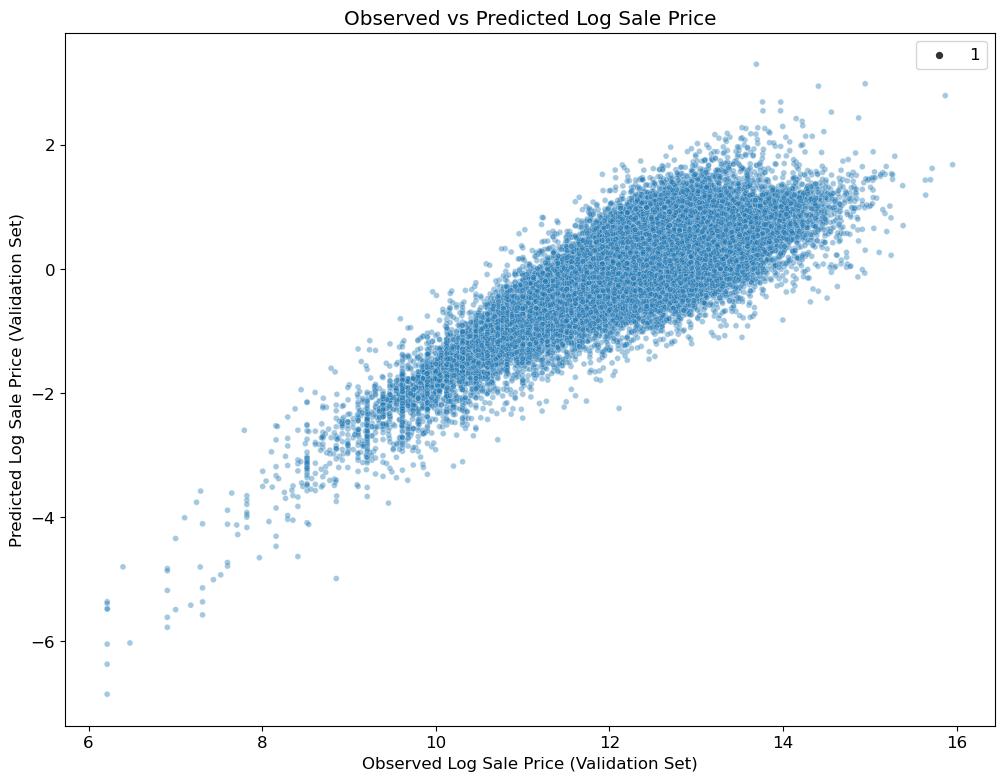

In [145]:
sns.scatterplot(y_valid_m2, y_valid_m2-y_predicted_m2, size=1, alpha=0.4)
plt.xlabel("Observed Log Sale Price (Validation Set)")
plt.ylabel("Predicted Log Sale Price (Validation Set)")
plt.title("Observed vs Predicted Log Sale Price")

In [146]:
q7b = "regressive"

While our simple model explains some of the variability in price, there is certainly still a lot of room for improvement to be made -- one reason is we have been only utilizing 1 or 2 features (out of a total of 70+) so far! Can you engineer and incoporate more features to improve the model's fairness and accuracy? We won't be asking you to provide your answers here, but this would be important going into the next part (also last part, wohoo!) of this project.

<br><br>

<hr style="border: 1px solid #fdb515;" />

## Building My Model

Let's define a linear regression model, then process training data using the `process_data_fm` function. Then, I use the model to predict `Log Sale Price` for the test data, transform the predicted and original log values back into their original forms (by using `delog`), and compute the test RMSE.

In [148]:
# Uncomment the line below to clean up memory from previous questions and reinitialize Otter!
# MAKE SURE TO COMMENT THE NEXT 3 LINES OUT BEFORE SUBMITTING!
# %reset -f
#del training_val_data, test_data, train, validation, X_train_m1, X_valid_m1, X_train_m2, X_valid_m2
import otter
grader = otter.Notebook("projA2.ipynb")

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model as lm

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

from ds100_utils import *
from feature_func import *

from sklearn.preprocessing import OneHotEncoder

<br><br>

---

## Finding Potential Features

**Features with higher correlation coefficients with the Log Sale Price:**
"Building Square Feet"

"Estimate (Building)"

"Age" 

"Latitude"

"Basement"

"Number of Bathrooms" <-- need to extract out with regex

"Number of Bedrooms" <-- need to extract out with regex

"Number of total rooms" <-- need to extract out with regex

"Porch"

"Central Air"

"Pure Market Filter"

"Garage 1 Size"

"in_expensive_neighborhood"


<br><br>

---

## More EDA

Let's conduct more EDA to understand underlying correlations between certain features to avoid over or underpredicting housing prices. 


<details>
    <summary>[<b>Click to Expand</b>] Some potential ideas I explore. </summary>
    
* Plot the distribution of a varaible. Is this varaible heavily skewed? Are there any outliers?

* Make a scatter plot between a continous feature and the outcome. Is there a relationship? Is there a transformation that may linearize the relationship?

* Make a plot of a categorical/discrete feature and the outcome. Is there a relationship? How can we transformation this categorical data into numerical features that can be useful for OLS?

* Find the correlation coefficient between features and the outcome. Is there a strong relationship between the two? Can you find the correlation coefficient between different transformations of the feature and the outcome?

</details>

In [149]:
training_val_data.head()

,PIN,Property Class,Neighborhood Code,Land Square Feet,Town Code,Apartments,Wall Material,Roof Material,Basement,Basement Finish,...,Sale Month of Year,Sale Half of Year,Most Recent Sale,Age Decade,Pure Market Filter,Garage Indicator,Neigborhood Code (mapping),Town and Neighborhood,Description,Lot Size
0,17294100610000,203,50,2500.0,76,0.0,2.0,1.0,1.0,3.0,...,9,2,1.0,13.2,0,0.0,50,7650,"This property, sold on 09/14/2015, is a one-st...",2500.0
1,13272240180000,202,120,3780.0,71,0.0,2.0,1.0,1.0,1.0,...,5,1,1.0,9.6,1,1.0,120,71120,"This property, sold on 05/23/2018, is a one-st...",3780.0
2,25221150230000,202,210,4375.0,70,0.0,2.0,1.0,2.0,3.0,...,2,1,0.0,11.2,1,1.0,210,70210,"This property, sold on 02/18/2016, is a one-st...",4375.0
3,10251130030000,203,220,4375.0,17,0.0,3.0,1.0,1.0,3.0,...,7,2,1.0,6.3,1,1.0,220,17220,"This property, sold on 07/23/2013, is a one-st...",4375.0
4,31361040550000,202,120,8400.0,32,0.0,3.0,1.0,2.0,3.0,...,6,1,0.0,6.3,1,1.0,120,32120,"This property, sold on 06/10/2016, is a one-st...",8400.0


<AxesSubplot:xlabel='Land Square Feet', ylabel='Density'>

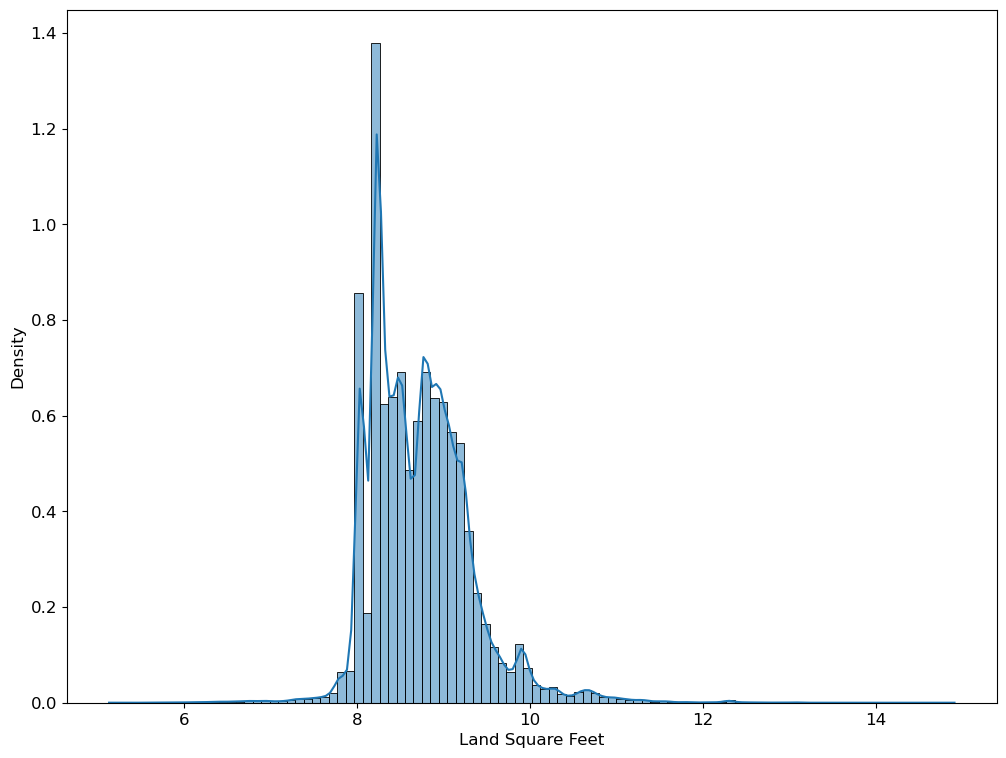

In [150]:
log_land_sf = np.log(training_val_data['Land Square Feet'])
sns.histplot(log_land_sf, kde=True, stat='density', bins=100)

In [151]:
#calculating correlation coefficients with different features
bsf_corr = training_val_data['Building Square Feet'].corr(np.log(training_val_data['Sale Price']))
print(bsf_corr)
eb_corr = training_val_data['Estimate (Building)'].corr(np.log(training_val_data['Sale Price']))
print(eb_corr)
age_corr = training_val_data['Age'].corr(np.log(training_val_data['Sale Price']))
print(age_corr)
lat_corr = training_val_data['Latitude'].corr(np.log(training_val_data['Sale Price']))
print(lat_corr)
bas_corr = training_val_data['Basement'].corr(np.log(training_val_data['Sale Price']))
print(bas_corr)
#bath_corr = training_val_data['Number of Bathrooms'].corr(np.log(training_val_data['Sale Price']))
#print(bath_corr)
#bed_corr = training_val_data['Number of Bedrooms'].corr(np.log(training_val_data['Sale Price']))
#print(bed_corr)
porch_corr = training_val_data['Porch'].corr(np.log(training_val_data['Sale Price']))
print(porch_corr)
ca_corr = training_val_data['Central Air'].corr(np.log(training_val_data['Sale Price']))
print(ca_corr)
pmf_corr = training_val_data['Pure Market Filter'].corr(np.log(training_val_data['Sale Price']))
print(pmf_corr)

0.12190222687829995
0.11809951865871851
-0.13147728991077787
0.13189771123131436
0.03931118577088731
0.025961993091610472
0.11215591060013327
0.9701089453193393


<AxesSubplot:xlabel='Age', ylabel='Building Square Feet'>

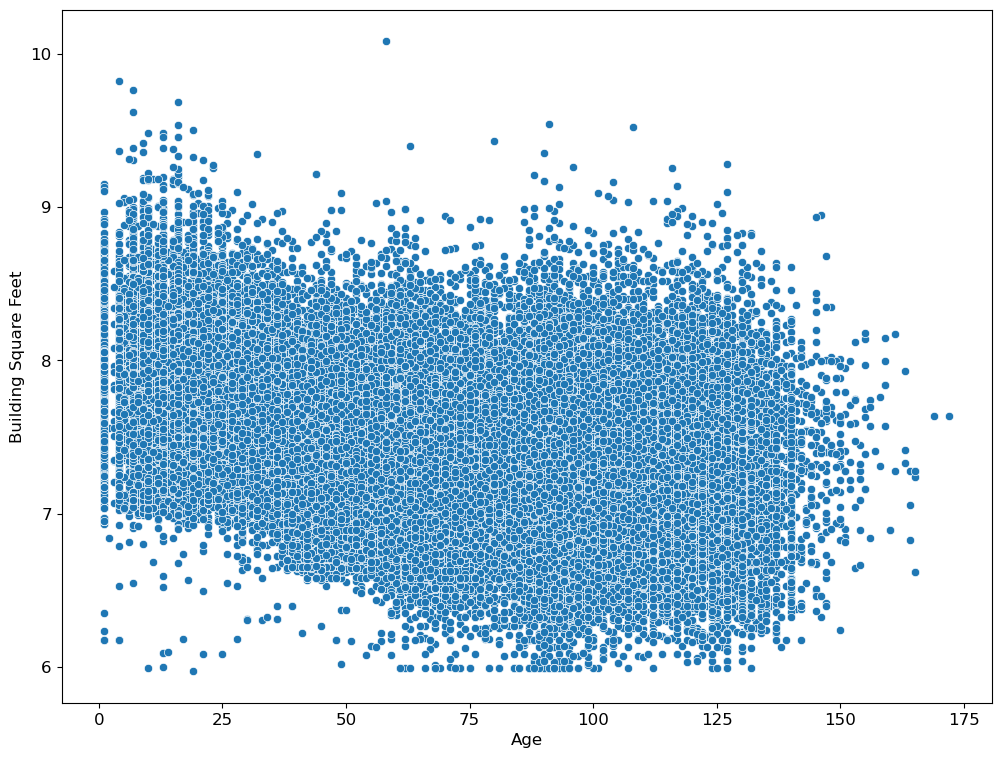

In [152]:
sns.scatterplot(data=training_val_data, x='Age', y=np.log(training_val_data['Building Square Feet']))

<AxesSubplot:xlabel='Garage 2 Size', ylabel="O'Hare Noise">

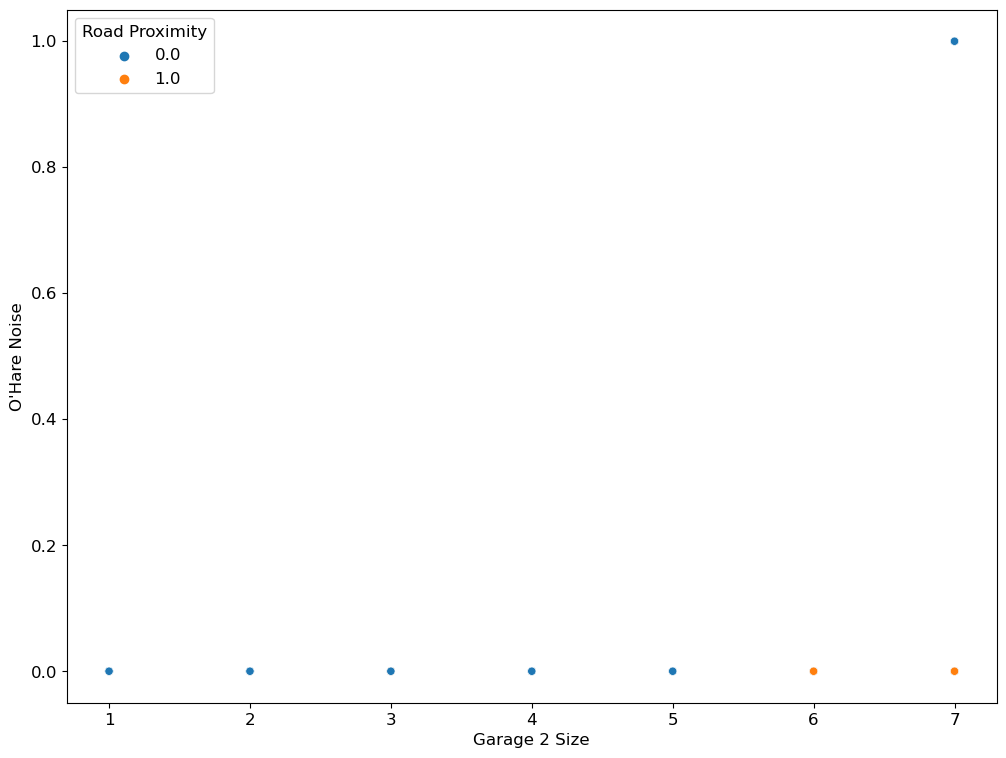

In [153]:
sns.scatterplot(data=training_val_data, y="O'Hare Noise", x='Garage 2 Size', hue='Road Proximity')

<AxesSubplot:xlabel='Site Desirability', ylabel="O'Hare Noise">

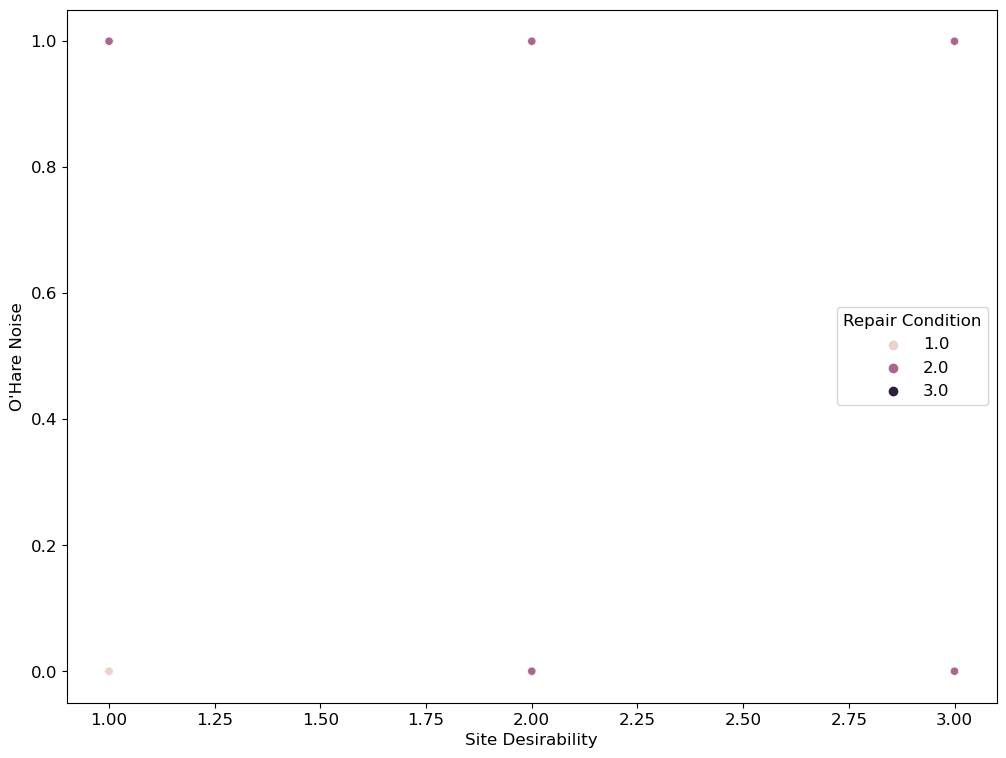

In [154]:
sns.scatterplot(data=training_val_data, x='Site Desirability', y = "O'Hare Noise", hue = 'Repair Condition')

In [155]:
lot_size_corr = training_val_data['Lot Size'].corr(training_val_data['Sale Price'])
lot_size_corr

0.1144558131632875

<AxesSubplot:xlabel='Lot Size', ylabel='Percent'>

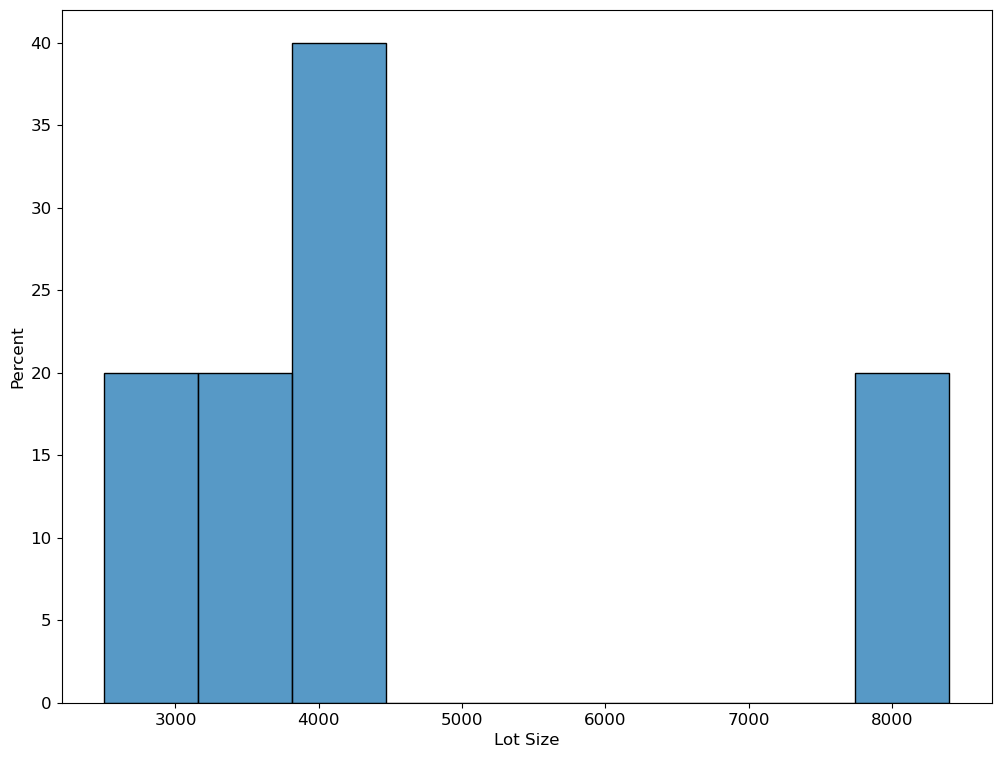

In [156]:
sns.histplot(x=training_val_data['Lot Size'].head(), stat='percent')

<br><br>

---

## Helper Functions and Variables for My Model

In [269]:
def train_val_split(data):
    data_len = data.shape[0]
    shuffled_indices = np.random.permutation(data_len) # shuffles indicies, but in a pre-determined way
    
    train_indicies = shuffled_indices[: int(len(shuffled_indices)*0.8)] #selecting the first 80% of shuffled indicies
        #we have randomization and are selecting pre-determined values for comparable train vs validation split
    validation_indicies = shuffled_indices[int(len(shuffled_indices)*0.8):] #selecting the last 20% of indicies 
    
    train = data.iloc[train_indicies]
    validation = data.iloc[validation_indicies]
   
    return train, validation

def add_total_bathrooms(data):
    """
    Input:
      data (data frame): a data frame containing at least the Description column.
    """
    with_rooms = data.copy()
    rooms_regex = r'and (\d+\.\d+) of which are bathrooms'
    rooms = with_rooms['Description'].str.extract(rooms_regex).astype(float)
    with_rooms['Bathrooms'] = rooms
    return with_rooms

def add_total_rooms(data):
    """
    Input:
      data (data frame): a data frame containing at least the Description column.
    """
    with_rooms = data.copy()
    rooms_regex = r"total\s+of\s+(\d+)\s+rooms"
    rooms = with_rooms['Description'].str.extract(rooms_regex).astype(float)
    with_rooms['Total Rooms'] = rooms
    return with_rooms

training_val_data = add_total_bedrooms(training_val_data)
training_val_data = add_total_bathrooms(training_val_data)
training_val_data = add_total_rooms(training_val_data)
training_val_data = substitute_roof_material(training_val_data)
#training_val_data = ohe_roof_material(training_val_data)

# Run this cell to define process_data_gm and select_columns, no futher actions needed.
def process_data_gm(data, pipeline_functions, prediction_col):
    """Process the data for a guided model."""
    for function, arguments, keyword_arguments in pipeline_functions:
        if keyword_arguments and (not arguments):
            data = data.pipe(function, **keyword_arguments)
        elif (not keyword_arguments) and (arguments):
            data = data.pipe(function, *arguments)
        else:
            data = data.pipe(function)
    X = data.drop(columns=[prediction_col])
    y = data.loc[:, prediction_col]
    return X, y

def rmse(predicted, actual):
    """
    Calculates RMSE from actual and predicted values
    Input:
      predicted (1D array): vector of predicted/fitted values
      actual (1D array): vector of actual values
    Output:
      a float, the root-mean square error
    """
    return np.sqrt(np.mean((actual - predicted)**2))


training_val_data.head()

,PIN,Property Class,Neighborhood Code,Land Square Feet,Town Code,Apartments,Wall Material,Roof Material,Basement,Basement Finish,...,Age Decade,Pure Market Filter,Garage Indicator,Neigborhood Code (mapping),Town and Neighborhood,Description,Lot Size,Bedrooms,Bathrooms,Total Rooms
0,17294100610000,203,50,2500.0,76,0.0,2.0,Shingle/Asphalt,1.0,3.0,...,13.2,0,0.0,50,7650,"This property, sold on 09/14/2015, is a one-st...",2500.0,3,1.0,6.0
1,13272240180000,202,120,3780.0,71,0.0,2.0,Shingle/Asphalt,1.0,1.0,...,9.6,1,1.0,120,71120,"This property, sold on 05/23/2018, is a one-st...",3780.0,3,1.0,6.0
2,25221150230000,202,210,4375.0,70,0.0,2.0,Shingle/Asphalt,2.0,3.0,...,11.2,1,1.0,210,70210,"This property, sold on 02/18/2016, is a one-st...",4375.0,3,1.0,7.0
3,10251130030000,203,220,4375.0,17,0.0,3.0,Shingle/Asphalt,1.0,3.0,...,6.3,1,1.0,220,17220,"This property, sold on 07/23/2013, is a one-st...",4375.0,3,1.5,5.0
4,31361040550000,202,120,8400.0,32,0.0,3.0,Shingle/Asphalt,2.0,3.0,...,6.3,1,1.0,120,32120,"This property, sold on 06/10/2016, is a one-st...",8400.0,2,1.0,5.0


<br><br>

---

## Pipeline Funtion

Now, we encapsulate as much of the data processing workflow into functions. I attempt to select the best features possible to build this model. 

<details>
    <summary>[<b>Click to Expand</b>] Hints: </summary>
    
* Some features may have missing values in the test set but not in the training/validation set. Make sure `process_data_fm` handles missing values appropriately for each feature!
    
</details>


In [292]:
# Please include all of your feature engineering process inside this function.
# Do not modify the parameters of this function.
import sklearn.linear_model as lm
linear_model = lm.LinearRegression()

def process_data_fm(data, is_test_set=False):
    # Whenever you access 'Log Sale Price' or 'Sale Price', make sure to use the
    # condition is_test_set like this:
    train_set, valid_set = train_val_split(full_data)

    if not is_test_set:
        # do your processing for the training set (i.e. not the test set)
        # this can involve references to sale price!
        data['Log Sale Price'] = np.log(data['Sale Price'])
        
        exp_neighborhoods = find_expensive_neighborhoods(data)
                                          
        pipelines = [
        (remove_outliers, None, {'variable': 'Sale Price', 'lower': 499}),
        (log_transform, None, {'col': 'Sale Price'}),
        (log_transform, None, {'col': 'Building Square Feet'}),
        (log_transform, None, {'col': 'Lot Size'}),
        (log_transform, None, {'col': 'Land Square Feet'}),
        (add_total_bedrooms, [], {}),
        (add_total_bathrooms, [], {}),
        (add_total_rooms, [], {}),
        (add_in_expensive_neighborhood, [], {'neighborhoods': exp_neighborhoods}),
        (select_columns, ['Log Sale Price', 'Log Building Square Feet', 'Age', 'Log Lot Size',
                          'Basement Finish', 'Garage 1 Size', 'Log Land Square Feet', 'Apartments',
                          'Fireplaces', 'Bathrooms', 'Total Rooms', 'Latitude', 'Longitude',
                        'Town Code',
                         'Bedrooms'], None)
        ]
                                

    else:
        # do your processing for the test set
        # this CANNOT involve references to sale price!
        exp_neighborhoods = find_expensive_neighborhoods(data)
        data = add_in_expensive_neighborhood(data, exp_neighborhoods)
        
        pipelines = [
        (log_transform, None, {'col': 'Building Square Feet'}),
        (log_transform, None, {'col': 'Lot Size'}),
        (log_transform, None, {'col': 'Land Square Feet'}),
        (add_total_bedrooms, [], {}),
        (add_total_bathrooms, [], {}),
        (add_total_rooms, [], {}),
        (add_in_expensive_neighborhood, [], {'neighborhoods': exp_neighborhoods}),
        (select_columns, ['Log Building Square Feet', 'Age', 'Log Lot Size',
                          'Basement Finish', 'Garage 1 Size', 'Log Land Square Feet', 'Apartments',
                          'Fireplaces', 'Bathrooms', 'Total Rooms', 'Latitude', 'Longitude',
                        'Town Code',
                         'Bedrooms'], None)
        ]
                                                                                                    
        
    
    # do your processing for the both train and test set
    X_train, y_train = process_data_gm(train_set, pipelines, 'Log Sale Price')                                     
    X_valid, y_valid = process_data_gm(valid_set, pipelines, 'Log Sale Price')
    
    # Return predictors and response variable separately
    if is_test_set:
        # Optional processing you wish to do, remove ellipsis before submission
        # Predictors
        X = X_valid
        return X
    else:
        # Optional processing you wish to do, remove ellipsis before submission 
        # Predictors. Your X should not include Log Sale Price!
        X = X_train
        # Response variable
        y = y_train
        
        return X, y

# DO NOT EDIT THESE TWO LINES!
check_rmse_threshold = run_linear_regression_test_optim(lm.LinearRegression(fit_intercept=True), process_data_fm, 'cook_county_train.csv', None, False)
print("Current training RMSE:", check_rmse_threshold.loss)

Current training RMSE: 240988.08169075116


<br><br>

---

## Fitting and Evaluating My Model

<details>
    <summary>[<b>Click to Expand</b>] Notes: </summary>
    
Train set:

* Check your test RMSE. Is this a reasonable number? You may use our grading scheme as reference. Keep in mind that training error is generally less than testing error. 

Test set:
* Find the original data shape at the begining of the notebook (in the provided assert statement). What should the output shape be?

* Since test and training/validation sets comes from the same population (recall that test and training/validation sets are a random split from a larger data), we expect our test prediction to have a similar range as the training data. Plot the observed training (Log) Sale Price and the predicted (Log) Sale Price. Are the ranges similar? Do you have any unreasonable extreme prediction that cannot be exponentiated?

* We cannot compute test RMSE directly since we do not have the observed values. Perform a holdout-test or cross validation (on training/validation sets) to estimate your test error. Recall that we are treating validation set as unseen data.
    
</details>

In [294]:
# Use this space to evaluate your model
# if you reset your memory, you need to define the functions again

<br><br>

---

## Model Selection

<details>
    <summary>[<b>Click to Expand</b>] Hints and ideas. </summary>

* How can you tell if the model is overfitting? Underfitting?

* If you are using the function `remove_outliers`, you may treat your `upper` and `lower` parameters as model hyperparameters. How can we use cross validation or holdout method to choose the best cutoff?
    
* If you are choosing how many features to keep, consider reviewing and reusing the idea from Lab 8.
    
</details>

In [295]:
# Use this space to test different models.

<br><br>

---

## Comparing Prediction with the Test Set

In [ ]:
from datetime import datetime
from IPython.display import display, HTML

Y_test_pred = run_linear_regression_test(lm.LinearRegression(fit_intercept=True), process_data_fm, None, 'cook_county_train.csv', 'cook_county_contest_test.csv', 
                                         is_test = True, is_ranking = False, return_predictions = True
                                         )

# Construct and save the submission:
submission_df = pd.DataFrame({
    "Id": pd.read_csv('cook_county_contest_test.csv')['Unnamed: 0'], 
    "Value": Y_test_pred,
}, columns=['Id', 'Value'])
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = "submission_{}.csv".format(timestamp)
submission_df.to_csv(filename, index=False)

#print('Created a CSV file: {}.'.format("submission_{}.csv".format(timestamp)))
display(HTML("Download your test prediction <a href='" + filename + "' download>here</a>."))
print('You may now upload this CSV file to Gradescope for scoring.')#

In [ ]:
# Scratch space to check if your prediction is reasonable. See 4f for hints. 
# We will not reset submission count for mis-submission issues.
submission_df["Value"].describe()

<!-- BEGIN QUESTION -->

<br><br>

<hr style="border: 1px solid #fdb515;" />

## Building the Modeling Process

Before even creating our model, we discussed which features about a house might be most relevant/infuential when calculating a house price. By calculating the individual correlation coefficient beween each feature and the Log Sale Price, conducting EDA, and creating some visualization, we were able to see some interesting relationships between some of the data. This helped us boil down which features might be most useful. In office hours and during discussion, we learned that about 10 features will be ideal to create the most accurate model given our limited memory capacity. In our modeling process, we log transformed some columns to help with linearization within our pipeline, and then extracted relevant columns. After that, we made calls to the process_feature_gm function to simplify our code.

Initially, our RMSE was extremely high at around 500,000. After discussing which types of variables to give more weight to, such as square footage and number of rooms, we were able to workshop this and reduce it. 

<!-- BEGIN QUESTION -->

<br><br>

<hr style="border: 1px solid #fdb515;" />

## Question 6 Evaluating Model in Context

<br><br>

---

## Understanding the Residuals

The residual is the difference between what an algorithm predicts the property value to be and what it actually is. For an individual homeowner, this is incredibly important because it dictates how much property tax they have to pay, thus, the amount of money the local government has toawrds funding relevant public services. A positive residual means that the home is being undervalued while a negative residual means that it is being overvalued. Undervaluation can be beneficial in terms of the individual owners property taxes, but also means that they won't get as much money when attempting to sell the house. The opposite is true when the property is overvalued.

<!-- END QUESTION -->

In the case of the Cook County Assessor’s Office, Chief Data Officer Rob Ross states that fair property tax rates are contingent on whether property values are assessed accurately - that they’re valued at what they’re worth, relative to properties with similar characteristics. This implies that having a more accurate model results in fairer assessments. The goal of the property assessment process for the CCAO, then, is to be as accurate as possible. 

When the use of algorithms and statistical modeling has real-world consequences, we often refer to the idea of fairness as a measurement of how socially responsible our work is. But fairness is incredibly multifaceted: Is a fair model one that minimizes loss - one that generates accurate results? Is it one that utilizes "unbiased" data? Or is fairness a broader goal that takes historical contexts into account?

These approaches to fairness are not mutually exclusive. If we look beyond error functions and technical measures of accuracy, we'd not only consider _individual_ cases of fairness, but also what fairness - and justice - means to marginalized communities on a broader scale. We'd ask: What does it mean when homes in predominantly Black and Hispanic communities in Cook County are consistently overvalued, resulting in proportionally higher property taxes? When the white neighborhoods in Cook County are consistently undervalued, resulting in proportionally lower property taxes? 

Having "accurate" predictions doesn't necessarily address larger historical trends and inequities, and fairness in property assessments in taxes works beyond the CCAO's valuation model. Disassociating accurate predictions from a fair system is vital to approaching justice at multiple levels. Take Evanston, IL - a suburb in Cook County - as an example of housing equity beyond just improving a property valuation model: Their City Council members [recently approved reparations for African American residents](https://www.usnews.com/news/health-news/articles/2021-03-23/chicago-suburb-approves-government-reparations-for-black-residents).


<!-- BEGIN QUESTION -->

<br><br>

---

## Evaluating the Fairness of Property Assessments and Taxes

Fairness in taxes is almost entirely dependent in fairness in property assessments. It is not realistic to build a model that exactly 100% assesses a house to it's actual value. However, if we are able to minize the under and overvaluation, and able to ensure that these minor computation discreptances are equally distributed, then we are creating a more fair system. Right now, the main issue is that these differences are not evenly distributed; POC, particularly African-American home owners, disproprtionatly carry the tax burden due to an overvaluation of their properties. White owners carry less because their homes are undervalued. By minimizing the under and overvaluation and distributing it evenly, we can have more fair property taxation systems that are not impacted by the legacy of racial segregation and redlining in counties. 